# Wisconsin Card Sort

The following experiment learns to solve the Wisconsin Card Sort via reinforcement learning

In [12]:
from tensorflow.keras.layers import Input, Dense, Flatten
import tensorflow as tf

import numpy as np

from ntask.atrs import AtrModel, AtrMovingAverage
from ntask.callbacks import AtrLogger
from ntask.layers import Context
from ntask.models import NTaskModel
from ntask.flags import Verbosity
from ntask.utils import set_seed

In [13]:
def harmonic_mean(x):
    return 1 / tf.math.reduce_mean(1/x)
    
def standard_deviation(x, mean):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(x - mean)))

In [14]:
class AtrSMA(AtrMovingAverage):
    def __init__(self, num_periods, switch_threshold_scale, switch_threshold_offset, add_threshold=0.0, max_contexts=0):
        super(AtrSMA, self).__init__(switch_threshold_offset, add_threshold, max_contexts)
        self.dyn_switch_threshold = switch_threshold_offset
        self.switch_threshold_scale = switch_threshold_scale
        self.periods = num_periods
        
    
    def build(self, num_contexts):
        super(AtrSMA, self).build(num_contexts)
        self.sma_updates = tf.Variable(np.zeros(self.num_contexts), name="SMA_Update_Count", trainable=False, dtype=tf.int64)
        self.sma_values = tf.Variable(np.zeros((self.num_contexts, self.periods)), name="SMA_Period_Values", trainable=False, dtype=tf.float64)
    
    
    def context_loss_fn(self, context_delta):
        return tf.keras.losses.mean_squared_error(np.zeros(len(context_delta)), context_delta)
    
    
    def update_atr_value(self, context_loss, switched):
        if switched or not self.values_initialized[self.hot_context]:
            self.sma_values.scatter_nd_update([[self.hot_context]], [np.zeros(self.periods)])
            self.sma_updates.scatter_nd_update([[self.hot_context]], [0])
        
        # Update the SMA values and update counter
        self.sma_values.scatter_nd_update([[self.hot_context, self.sma_updates[self.hot_context] % self.periods]], [context_loss])
        self.sma_updates.scatter_nd_add([[self.hot_context]], [1])
        
        # Calculate the mean and standard deviation
        mean = tf.math.reduce_mean(self.sma_values[self.hot_context][:self.sma_updates[self.hot_context]])
        std = tf.math.reduce_std(self.sma_values[self.hot_context])
            
        # Update the ATR and STD values
        self.set_atr_value(mean)
        self.switch_threshold.assign(self.switch_threshold_scale*tf.cast(-std, tf.float32) + self.dyn_switch_threshold)
            
#     def should_switch(self, epoch, context_loss):
#         return False
            
#     def should_add_context(self, context_loss, best_fit_context_idx):
#         return False

In [15]:
def random_card(rule):
    """
    Generate a one-hot encoded card.
    Returns a tuple of the card and the expected output label
    """
    x = np.identity(3) # 4
    np.random.shuffle(x)
    return x[:3]

In [16]:
def policy(predicted, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(3), True
    return np.argmax(predicted), False

In [17]:
def reward(sort, rule):
    if sort == rule:
        return 5.0
    return -5.0

In [18]:
def episode(model, rule, ep, epsilon=0.01, alpha=0.5, gamma=0.95, callbacks=[]):
    # Random card to sort
    card = random_card(rule)
    card = card.reshape((1,) + card.shape)
    
    print(end=f"{ep}: ")
    
    # Predict and sort
    value = model.predict(card)[0]
    sort, is_random = policy(value, epsilon)
    r = reward(sort, rule)
    
    if is_random:
        print("Random action taken")
    
    # Q-learning update
    print(value, end=" => ")
    value[sort] += alpha*(r - value[sort])
    target = value.reshape((1,) + value.shape)
    print(target)
    model.fit(card, target, train_after_switch=False, find_best_fit=False, callbacks=callbacks, verbose=Verbosity.Contexts)
    
    return sort == rule, is_random

In [19]:
def wisconsin_card_sort(model, episodes, seq_correct=3, epsilon=0.01, alpha=0.5, gamma=0.95, callbacks=[], initial_shuffle=False, shuffle=True):
    NUM_DIMENSIONS = 3
    rule = 0 if not initial_shuffle else np.random.randint(NUM_DIMENSIONS)
    tried_all = False
    correct = 0
    print("Rule is:", rule)
    for ep in range(episodes):
        # Perform the episode. Count the sequentially correct episodes
        is_correct, is_random = episode(model, rule, ep, epsilon, alpha, gamma, callbacks)
        if is_correct:
            correct += 1
        else:
            correct = 0
            
        # Change the rule once the model has learned the rule
        if correct >= seq_correct:
            correct = 0
            if shuffle and (initial_shuffle or tried_all):
                oldrule = rule
                while rule == oldrule:
                    rule = np.random.randint(NUM_DIMENSIONS)
            else:
                if rule + 1 == NUM_DIMENSIONS:
                    tried_all = True
                rule = (rule + 1) % NUM_DIMENSIONS
            print(f"\nEpisode: {ep+1}; New rule is:", rule, '\n')

## Static n-task Learning

In [67]:
set_seed(2)

In [68]:
# Optimizer
# optimizer = tf.keras.optimizers.SGD(1e-1)
optimizer = tf.keras.optimizers.Adam(1e-2)

# Hyperparameters
hrr_size = 64
num_contexts = 3
switch_threshold = -1.5

# Model Architecture
inp = Input((3,3))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu", use_bias=False)(x)
x = Context(num_contexts, AtrMovingAverage(switch_threshold))(x)
x = Dense(3, activation="linear", use_bias=False)(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [69]:
episodes = 1000
seq_correct = 30
epsilon = 0.1
alpha = 1.0
gamma = 0.75

logger = AtrLogger(track_epochs_internally=True)
callbacks = [logger]

wisconsin_card_sort(model, episodes, seq_correct, epsilon, alpha, gamma, callbacks)

Rule is: 0
0: Random action taken
[-0.3592347  -0.01275272 -0.35699028] => [[-0.3592347  -0.01275272 -5.        ]]
1: [-0.05000715  0.21451156 -0.32315254] => [[-0.05000715 -5.         -0.32315254]]
2: [-0.0405277   0.01484657 -0.38585615] => [[-0.0405277  -5.         -0.38585615]]
3: [-0.27865526 -0.16699988  0.3656221 ] => [[-0.27865526 -0.16699988 -5.        ]]
4: [ 0.08725923 -0.25249815 -0.25822014] => [[ 5.         -0.25249815 -0.25822014]]
5: [-0.22938381 -0.3106256   0.08568858] => [[-0.22938381 -0.3106256  -5.        ]]
6: [ 0.16855435 -0.4242655  -0.6251976 ] => [[ 5.        -0.4242655 -0.6251976]]
7: [ 0.4199217  -0.40170988 -0.3721623 ] => [[ 5.         -0.40170988 -0.3721623 ]]
8: [-0.06278826 -0.39798415 -1.2916626 ] => [[ 5.         -0.39798415 -1.2916626 ]]
9: [ 0.5567788 -0.4952971 -0.7582058] => [[ 5.        -0.4952971 -0.7582058]]
10: [ 0.09277569 -0.5790379  -0.5949466 ] => [[ 5.        -0.5790379 -0.5949466]]
11: [ 0.87836397 -0.54605263 -0.8154193 ] => [[ 5.      

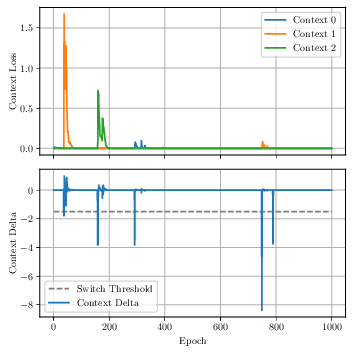

In [70]:
logger.plot(figsize=(5,5), savefile="graphs/wcst_static.pgf")

## 2. Dynamic n-Task

In [52]:
set_seed(2)

In [53]:
# Optimizer
# optimizer = tf.keras.optimizers.SGD(1e-1)
optimizer = tf.keras.optimizers.Adam(1e-2)

# Hyperparameters
hrr_size = 64
num_contexts = 3
switch_threshold = -1.5
add_threshold = -1.75
n_periods = 10

# Model Architecture
inp = Input((3,3))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu", use_bias=False)(x)
x = Context(1, AtrMovingAverage(switch_threshold, add_threshold=add_threshold, max_contexts=num_contexts))(x)
x = Dense(3, activation="linear", use_bias=False)(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [54]:
episodes = 1000
seq_correct = 30
epsilon = 0.1
alpha = 1.0
gamma = 0.75

logger = AtrLogger(track_epochs_internally=True)
callbacks = [logger]

wisconsin_card_sort(model, episodes, seq_correct, epsilon, alpha, gamma, callbacks)

Rule is: 0
0: Random action taken
[-0.3592347  -0.01275272 -0.35699028] => [[-0.3592347  -0.01275272 -5.        ]]
1: [-0.05000715  0.21451156 -0.32315254] => [[-0.05000715 -5.         -0.32315254]]
2: [-0.0405277   0.01484657 -0.38585615] => [[-0.0405277  -5.         -0.38585615]]
3: [-0.27865526 -0.16699988  0.3656221 ] => [[-0.27865526 -0.16699988 -5.        ]]
4: [ 0.08725923 -0.25249815 -0.25822014] => [[ 5.         -0.25249815 -0.25822014]]
5: [-0.22938381 -0.3106256   0.08568858] => [[-0.22938381 -0.3106256  -5.        ]]
6: [ 0.16855435 -0.4242655  -0.6251976 ] => [[ 5.        -0.4242655 -0.6251976]]
7: [ 0.4199217  -0.40170988 -0.3721623 ] => [[ 5.         -0.40170988 -0.3721623 ]]
8: [-0.06278826 -0.39798415 -1.2916626 ] => [[ 5.         -0.39798415 -1.2916626 ]]
9: [ 0.5567788 -0.4952971 -0.7582058] => [[ 5.        -0.4952971 -0.7582058]]
10: [ 0.09277569 -0.5790379  -0.5949466 ] => [[ 5.        -0.5790379 -0.5949466]]
11: [ 0.87836397 -0.54605263 -0.8154193 ] => [[ 5.      

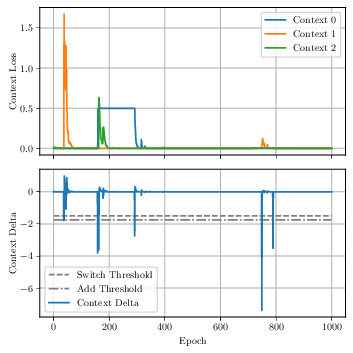

In [55]:
logger.plot(figsize=(5,5), savefile="graphs/wcst_dynamic.pgf")

## Dynamic n-task Learning

In [ ]:
set_seed(1)

In [ ]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size = 128
num_contexts = 3
switch_threshold = -0.01
add_threshold = -0.015
n_periods = 10

# Model Architecture
inp = Input((3,4))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu")(x)
x = Context(1, AtrMovingAverage(switch_threshold, add_threshold, num_contexts))(x)
x = Dense(4, activation="linear")(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [ ]:
episodes = 400
seq_correct = 20
epsilon = 0.00
alpha = 1.0
gamma = 0.75

logger = AtrLogger(track_epochs_internally=True)
callbacks = [logger]

wisconsin_card_sort(model, episodes, seq_correct, epsilon, alpha, gamma, callbacks)

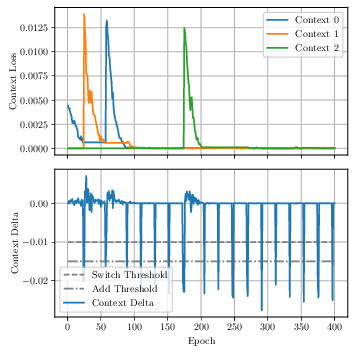

In [61]:
logger.plot(figsize=(5,5), savefile="graphs/wcst_dynamic.pgf")